In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
#train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)

In [4]:
def one_hot(y, batch_size):
    oh = torch.zeros([batch_size, class_size])
    for st,idx in enumerate(y): 
        try:
            oh[st][idx] = 1 
        except:
            print ('st=', type(st), ' idx=', type(idx), idx.shape)
            raise
    return oh   

In [5]:
class_size = 10
batch_size = 50
batch_zeros = torch.zeros((batch_size, 1))
batch_ones = torch.ones((batch_size, 1))

fixed_data, fixed_cl = next(iter(test_loader))
fixed_z = torch.randn((50, 16))
fixed_oh = one_hot(y=fixed_cl[:50], batch_size=50)
fixed_h = torch.cat((fixed_z, fixed_oh), 1) 

In [6]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.LeakyReLU(0.1), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [7]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.LeakyReLU(0.1), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [8]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [9]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
        
        self.latent_size = 16
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None)
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None)
        
        self.latent_fn = nn.Sigmoid()
                    
        self.fce = FullyConnected([32*2*2, self.latent_size])
        self.fcd = FullyConnected([self.latent_size + class_size, 32*2*2])
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
    
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
                    
        self.discr = FullyConnected([self.latent_size, 256, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)       
        self.d_optimizer = optim.Adam(self.discr.parameters(), **optim_params)
       
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        h = self.latent_fn(self.fce(flatten))
        return h
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def discriminator(self, x):        
        x = self.discr(x)       
        return x
                
    def forward(self, x, y):
        self.h = self.encode(x)
        oh = one_hot(y=y, batch_size=batch_size)
        encoded_oh = torch.cat((self.h, oh), 1) 
        x = self.decode(encoded_oh)
        return x
    
    def ae_loss(self, data, label):
        
       # oh = one_hot(y=label, batch_size=batch_size)
       # 
       # encoded_oh = torch.cat((encoded, oh), 1) 
    
        output = self.forward(data, label)        
        mse_loss = F.mse_loss(output, data) 
         
        encoded = self.encode(data)
        fake_pred = self.discriminator(encoded) 
        discr_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)        
        
        self._ae_loss = mse_loss + discr_loss
                        
        return self._ae_loss
    
    def ds_loss(self, data):
                       
        encoded = self.encode(data)           
        fake_pred = self.discriminator(encoded)
        true_pred = self.discriminator(torch.randn((batch_size, model.latent_size)))

        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones) 
        self._ds_loss = 0.5*(fake_loss + true_loss)
        
        return self._ds_loss

In [10]:
models = {
    'Adam Discr': Net(False, False, optim_type='Adam', lr=1e-4),
    'Adam Discr+bn+dp': Net(True, True, optim_type='Adam', lr=1e-4),
}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [11]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, label) in enumerate(train_loader):
        for model in models.values():
            
            # train discriminator
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
                     
            ds_loss = model.ds_loss(data)        
            ds_loss.backward()
            model.d_optimizer.step()
                        
            # train AE
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
                      
            ae_loss = model.ae_loss(data, label)            
            ae_loss.backward()
            model.optim.step()
                       
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: AE:{:.4f} D:{:.4f}'.format(k, m._ae_loss.item(), m._ds_loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: AE:{:.4f} D:{:.4f}'.format(k, m._ae_loss.item(), m._ds_loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._ae_loss, models[k]._ds_loss))
        print(line + losses)

In [12]:
def plot_latent(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

    plt.show()
    

In [13]:
def test(models, loader, log=None):
    test_size = len(loader)
    test_ae_loss = {k: 0. for k in models}
    test_discr_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, label in loader:
            output = {k: m.forward(data, label) for k, m in models.items()}
            for k, m in models.items():                
                test_ae_loss[k] += m.ae_loss(data, label).item() 
                test_discr_loss[k] += m.ds_loss(data).item() 
    
    for k in models:
        test_ae_loss[k] /= test_size
        test_discr_loss[k] /= test_size 
    report = 'Test losses: ' + ' '.join(['{}: {:.8f}/{:.8f}'.format(k, test_ae_loss[k], test_discr_loss[k]) 
                                         for k in models])
    if log is not None:
        for k in models:
            log[k].append((test_ae_loss[k],))
            with torch.no_grad():
                ae_data = models[k].forward(fixed_data, fixed_cl).data.numpy()
                fixed_gen = models[k].decode(fixed_h).data.numpy()
                plot_mnist(ae_data, (5, 10))
                plot_mnist(fixed_gen, (5, 10)) 
                
                encoded = model.encode(fixed_data)
                enc_to_lot = encoded.view(-1, 1, 4, 4).clamp(-1, 1).data.numpy()
                plot_latent(enc_to_lot, (5, 10))
            
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses Adam Discr: AE:1.5998 D:0.6893 Adam Discr+bn+dp: AE:1.8465 D:0.7072
Train Epoch: 1 [10000/50000 (20%)]	Losses Adam Discr: AE:1.8810 D:0.2320 Adam Discr+bn+dp: AE:2.6149 D:0.1758
Train Epoch: 1 [20000/50000 (40%)]	Losses Adam Discr: AE:3.1322 D:0.0631 Adam Discr+bn+dp: AE:3.1690 D:0.0643
Train Epoch: 1 [30000/50000 (60%)]	Losses Adam Discr: AE:2.8460 D:0.0647 Adam Discr+bn+dp: AE:4.0554 D:0.0314
Train Epoch: 1 [40000/50000 (80%)]	Losses Adam Discr: AE:5.3012 D:0.0120 Adam Discr+bn+dp: AE:4.8164 D:0.0110
Train Epoch: 1 [50000/50000 (100%)]	Losses Adam Discr: AE:5.6164 D:0.0053 Adam Discr+bn+dp: AE:5.3213 D:0.0057


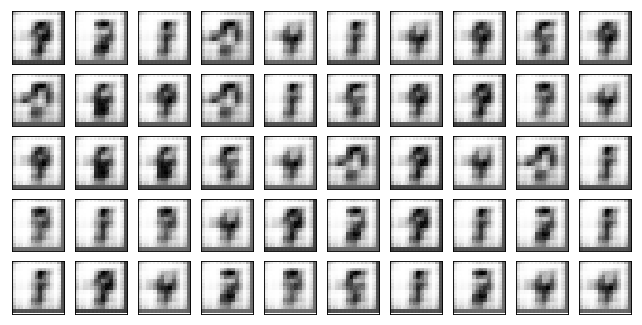

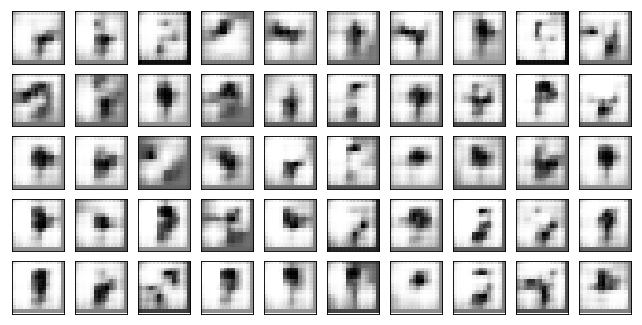

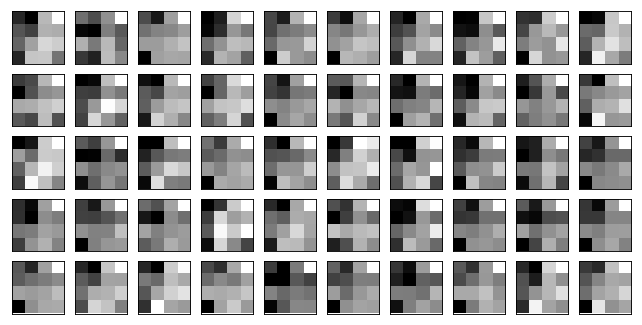

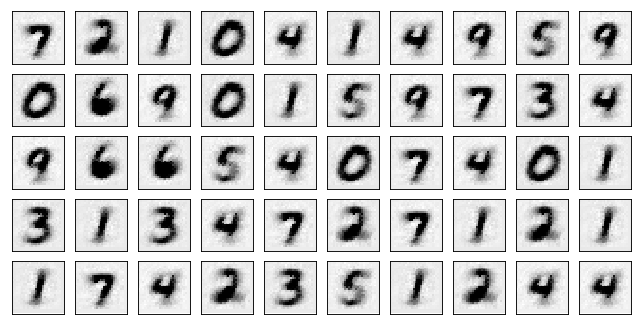

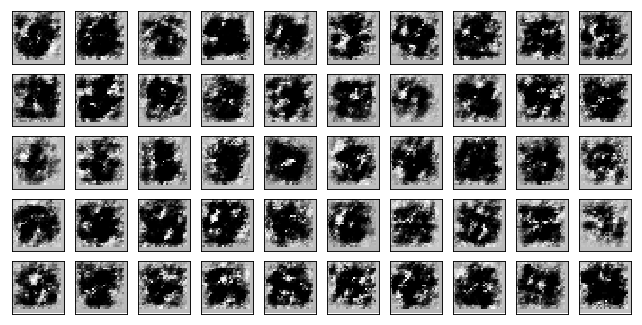

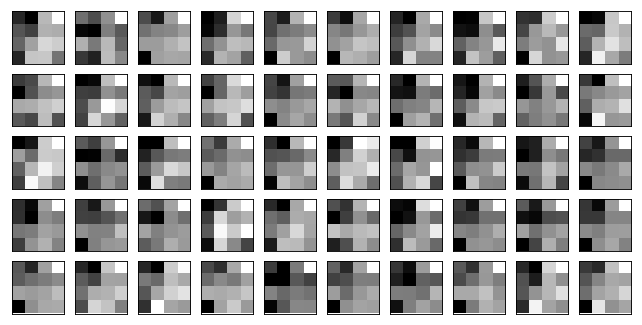

Test losses: Adam Discr: 5.79675857/0.00359929 Adam Discr+bn+dp: 5.34603981/0.00528383
Train Epoch: 2 [0/50000 (0%)]	Losses Adam Discr: AE:5.8150 D:0.0074 Adam Discr+bn+dp: AE:5.2545 D:0.0082
Train Epoch: 2 [10000/50000 (20%)]	Losses Adam Discr: AE:5.9326 D:0.0030 Adam Discr+bn+dp: AE:5.7038 D:0.0037
Train Epoch: 2 [20000/50000 (40%)]	Losses Adam Discr: AE:6.3710 D:0.0044 Adam Discr+bn+dp: AE:6.0638 D:0.0035
Train Epoch: 2 [30000/50000 (60%)]	Losses Adam Discr: AE:6.4841 D:0.0014 Adam Discr+bn+dp: AE:6.2693 D:0.0019
Train Epoch: 2 [40000/50000 (80%)]	Losses Adam Discr: AE:7.0233 D:0.0011 Adam Discr+bn+dp: AE:6.7200 D:0.0015
Train Epoch: 2 [50000/50000 (100%)]	Losses Adam Discr: AE:7.1746 D:0.0009 Adam Discr+bn+dp: AE:6.6990 D:0.0016


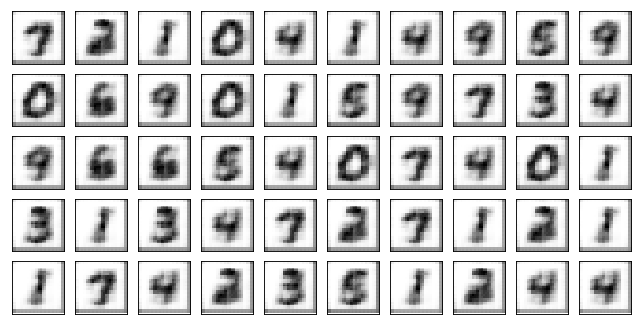

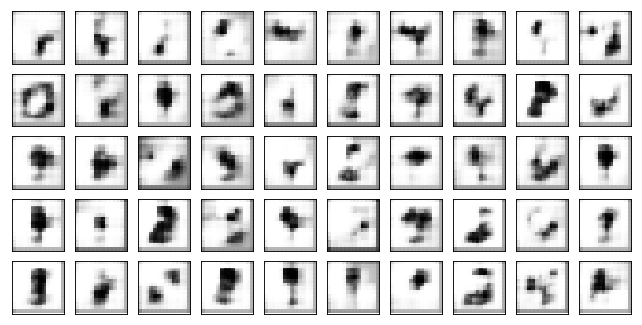

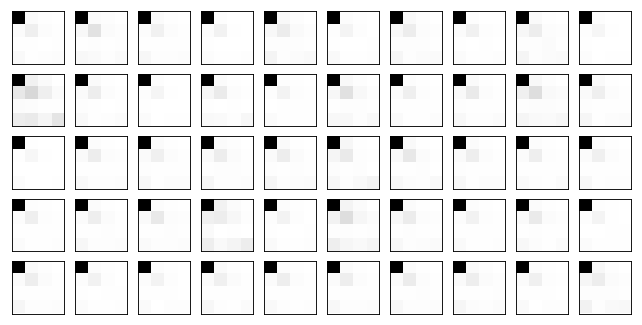

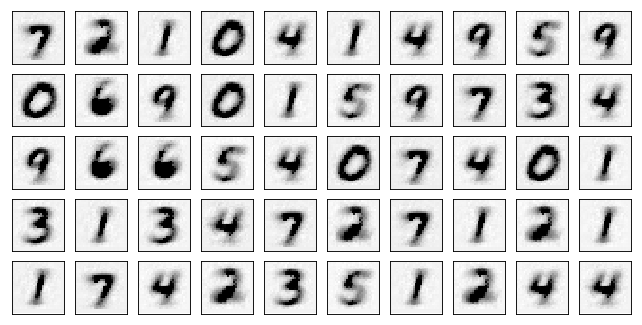

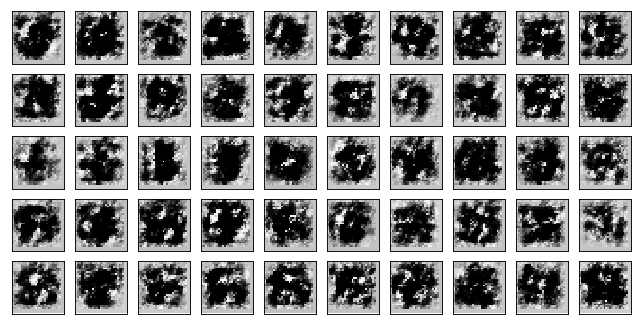

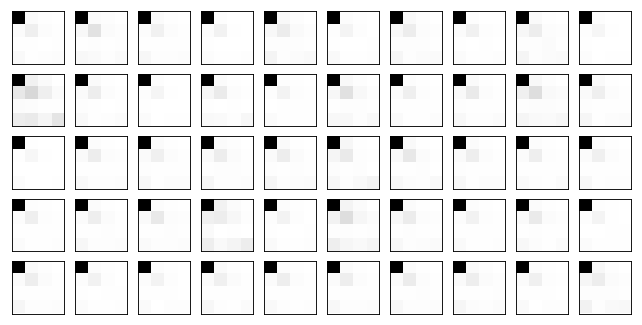

Test losses: Adam Discr: 7.18866466/0.00076237 Adam Discr+bn+dp: 6.80000646/0.00105171
Train Epoch: 3 [0/50000 (0%)]	Losses Adam Discr: AE:7.2127 D:0.0015 Adam Discr+bn+dp: AE:6.6832 D:0.0031
Train Epoch: 3 [10000/50000 (20%)]	Losses Adam Discr: AE:7.9604 D:0.0083 Adam Discr+bn+dp: AE:7.7990 D:0.0029
Train Epoch: 3 [20000/50000 (40%)]	Losses Adam Discr: AE:6.6482 D:0.0057 Adam Discr+bn+dp: AE:7.5129 D:0.0030
Train Epoch: 3 [30000/50000 (60%)]	Losses Adam Discr: AE:8.1567 D:0.0009 Adam Discr+bn+dp: AE:6.9784 D:0.0020
Train Epoch: 3 [40000/50000 (80%)]	Losses Adam Discr: AE:7.8107 D:0.0021 Adam Discr+bn+dp: AE:6.8462 D:0.0045
Train Epoch: 3 [50000/50000 (100%)]	Losses Adam Discr: AE:7.8913 D:0.0005 Adam Discr+bn+dp: AE:6.6591 D:0.0085


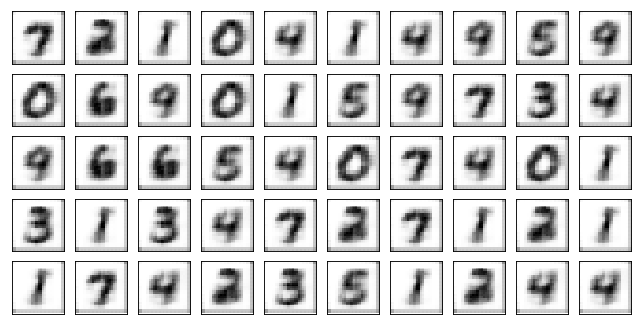

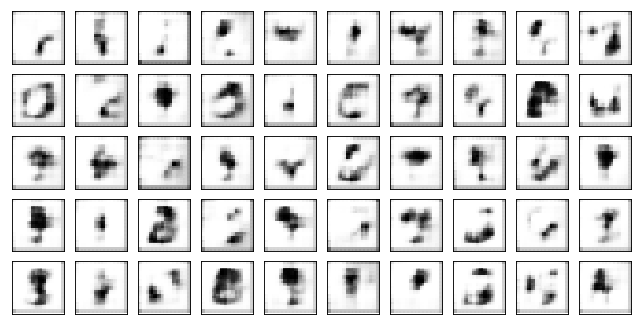

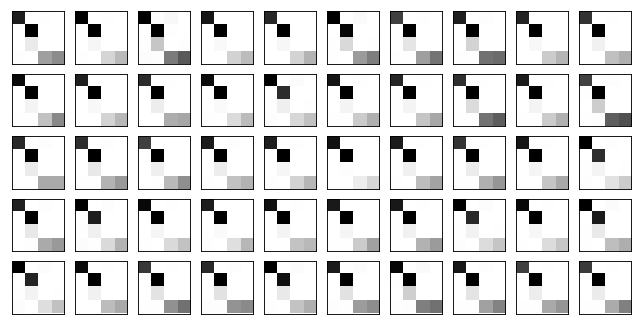

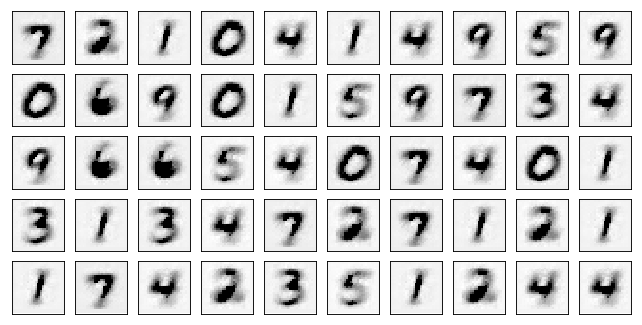

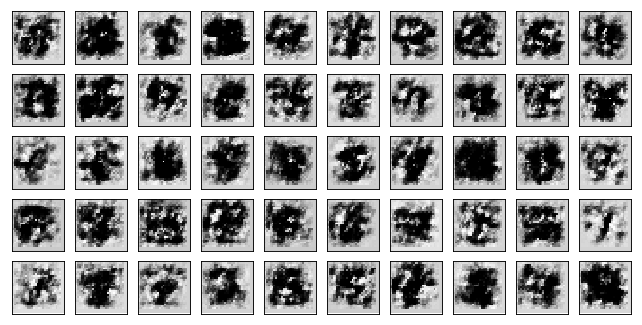

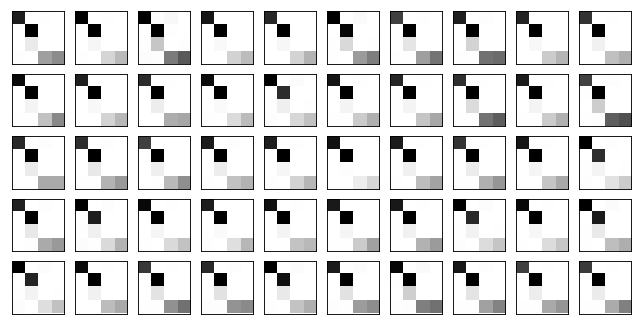

Test losses: Adam Discr: 8.00752632/0.00053592 Adam Discr+bn+dp: 8.79009221/0.00112637
Train Epoch: 4 [0/50000 (0%)]	Losses Adam Discr: AE:7.6689 D:0.0017 Adam Discr+bn+dp: AE:6.4091 D:0.0027
Train Epoch: 4 [10000/50000 (20%)]	Losses Adam Discr: AE:8.2609 D:0.0019 Adam Discr+bn+dp: AE:7.0074 D:0.0027
Train Epoch: 4 [20000/50000 (40%)]	Losses Adam Discr: AE:9.3360 D:0.0030 Adam Discr+bn+dp: AE:7.1510 D:0.0030
Train Epoch: 4 [30000/50000 (60%)]	Losses Adam Discr: AE:7.7533 D:0.0018 Adam Discr+bn+dp: AE:7.3723 D:0.0010
Train Epoch: 4 [40000/50000 (80%)]	Losses Adam Discr: AE:8.6383 D:0.0140 Adam Discr+bn+dp: AE:7.4042 D:0.0008
Train Epoch: 4 [50000/50000 (100%)]	Losses Adam Discr: AE:8.3927 D:0.0004 Adam Discr+bn+dp: AE:8.2552 D:0.0006


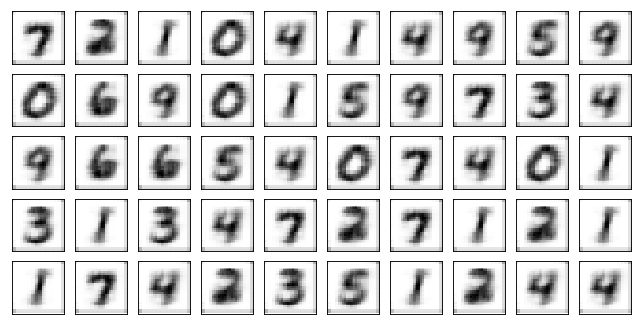

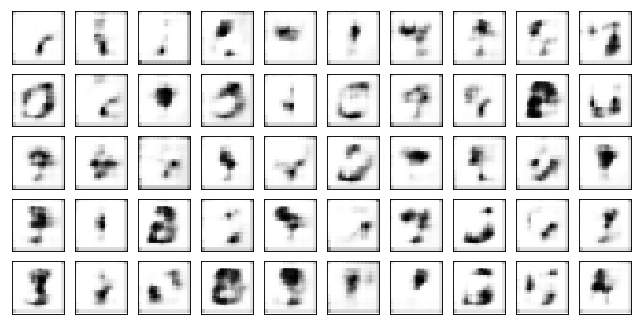

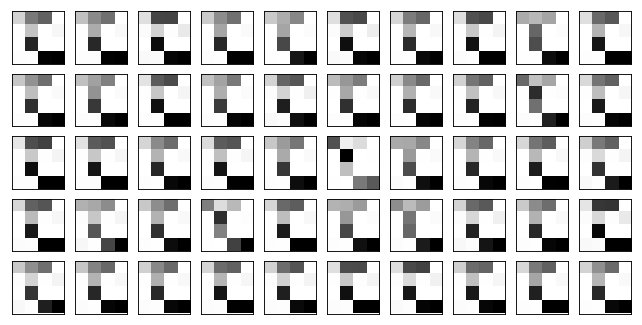

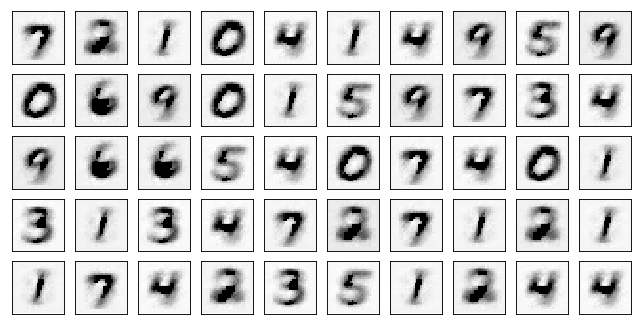

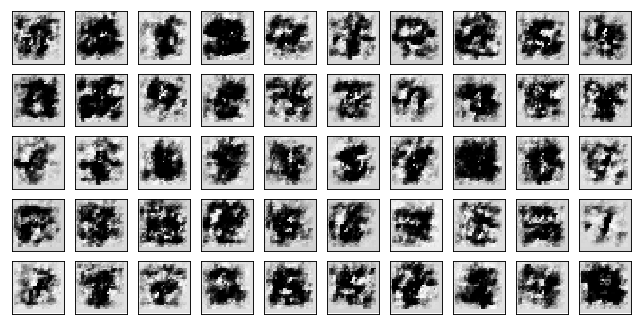

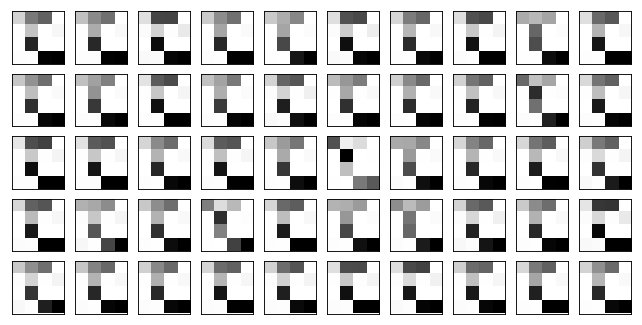

Test losses: Adam Discr: 8.65224583/0.00034087 Adam Discr+bn+dp: 10.47130540/0.00041601
Train Epoch: 5 [0/50000 (0%)]	Losses Adam Discr: AE:8.6403 D:0.0007 Adam Discr+bn+dp: AE:7.9075 D:0.0008
Train Epoch: 5 [10000/50000 (20%)]	Losses Adam Discr: AE:8.3737 D:0.0006 Adam Discr+bn+dp: AE:7.8540 D:0.0010
Train Epoch: 5 [20000/50000 (40%)]	Losses Adam Discr: AE:8.6881 D:0.0002 Adam Discr+bn+dp: AE:7.4041 D:0.0013
Train Epoch: 5 [30000/50000 (60%)]	Losses Adam Discr: AE:9.2500 D:0.0002 Adam Discr+bn+dp: AE:8.2321 D:0.0005
Train Epoch: 5 [40000/50000 (80%)]	Losses Adam Discr: AE:8.3935 D:0.0003 Adam Discr+bn+dp: AE:8.1451 D:0.0209
Train Epoch: 5 [50000/50000 (100%)]	Losses Adam Discr: AE:9.2307 D:0.0001 Adam Discr+bn+dp: AE:8.5493 D:0.0008


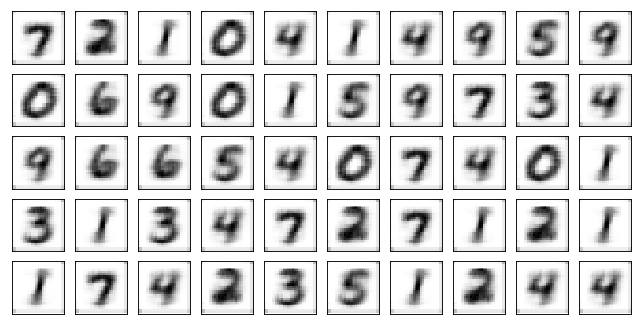

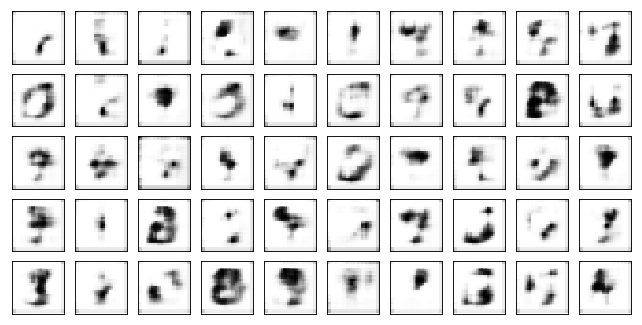

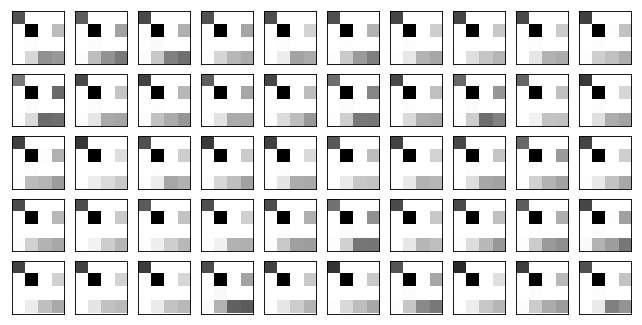

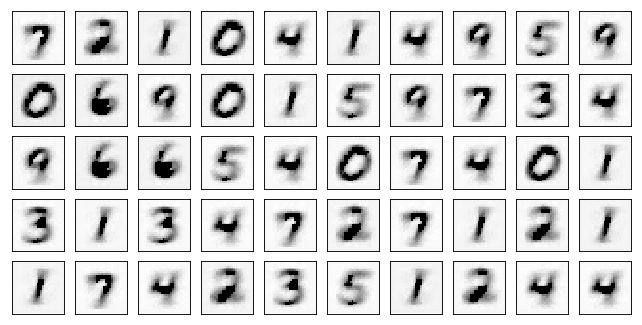

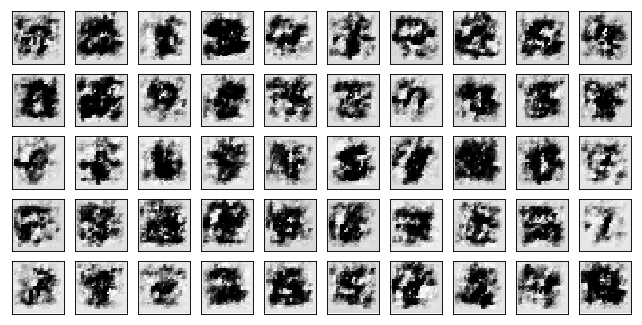

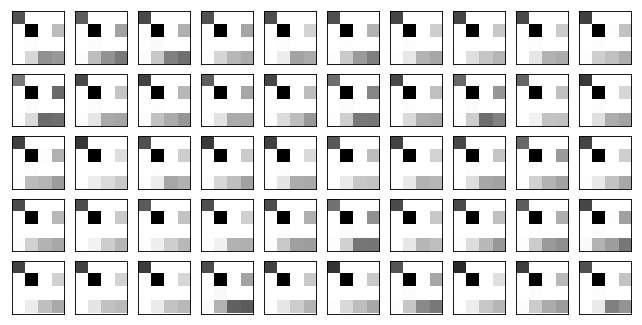

Test losses: Adam Discr: 9.60761796/0.00025412 Adam Discr+bn+dp: 9.99913053/0.00072024
Train Epoch: 6 [0/50000 (0%)]	Losses Adam Discr: AE:9.1860 D:0.0002 Adam Discr+bn+dp: AE:8.0044 D:0.0008
Train Epoch: 6 [10000/50000 (20%)]	Losses Adam Discr: AE:9.4719 D:0.0001 Adam Discr+bn+dp: AE:7.3217 D:0.0009
Train Epoch: 6 [20000/50000 (40%)]	Losses Adam Discr: AE:9.1995 D:0.0002 Adam Discr+bn+dp: AE:8.4919 D:0.0188
Train Epoch: 6 [30000/50000 (60%)]	Losses Adam Discr: AE:5.8724 D:0.0025 Adam Discr+bn+dp: AE:8.2621 D:0.0008
Train Epoch: 6 [40000/50000 (80%)]	Losses Adam Discr: AE:6.9161 D:0.0019 Adam Discr+bn+dp: AE:8.4637 D:0.0013
Train Epoch: 6 [50000/50000 (100%)]	Losses Adam Discr: AE:7.2440 D:0.0011 Adam Discr+bn+dp: AE:8.3021 D:0.0014


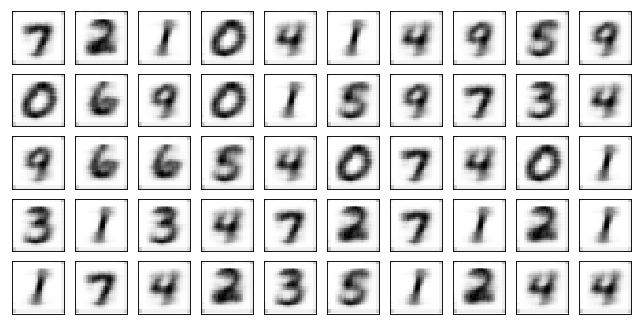

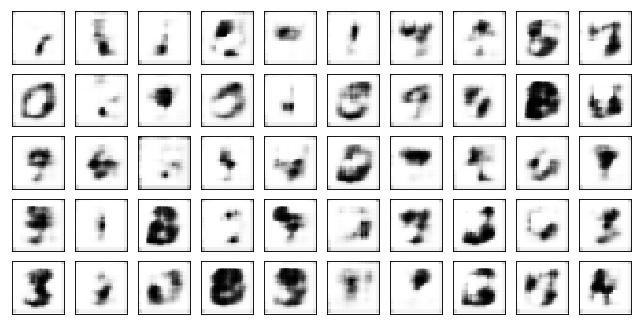

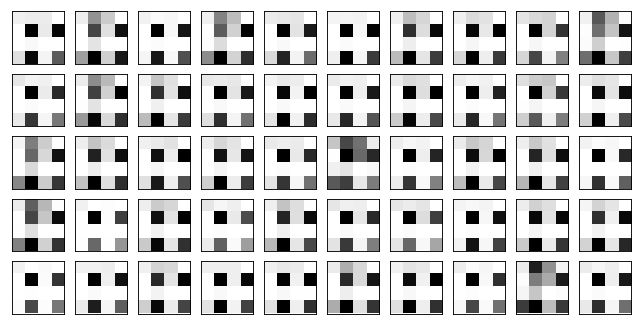

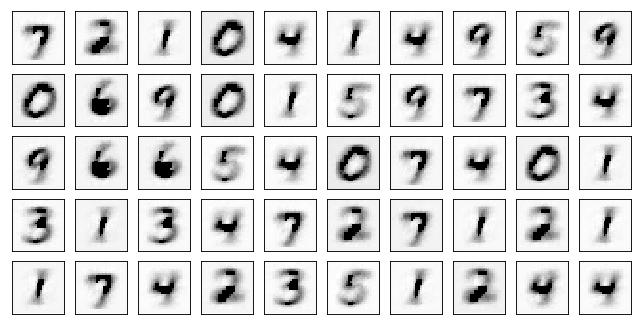

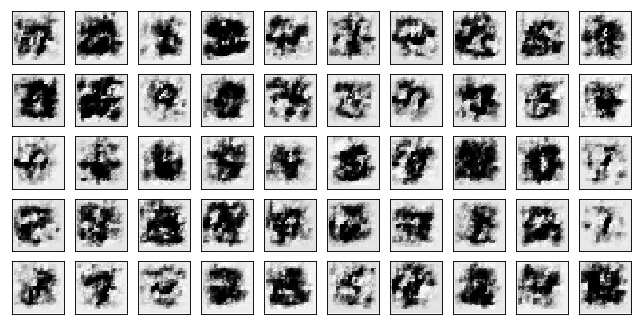

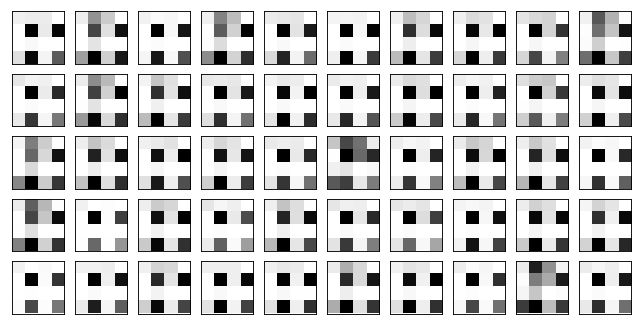

Test losses: Adam Discr: 7.23729980/0.00158335 Adam Discr+bn+dp: 11.53929189/0.00173226
Train Epoch: 7 [0/50000 (0%)]	Losses Adam Discr: AE:7.3000 D:0.0087 Adam Discr+bn+dp: AE:9.4153 D:0.0006
Train Epoch: 7 [10000/50000 (20%)]	Losses Adam Discr: AE:8.1019 D:0.0009 Adam Discr+bn+dp: AE:9.3193 D:0.0024
Train Epoch: 7 [20000/50000 (40%)]	Losses Adam Discr: AE:7.5093 D:0.0010 Adam Discr+bn+dp: AE:8.4042 D:0.0019
Train Epoch: 7 [30000/50000 (60%)]	Losses Adam Discr: AE:9.2359 D:0.0002 Adam Discr+bn+dp: AE:7.8329 D:0.0020
Train Epoch: 7 [40000/50000 (80%)]	Losses Adam Discr: AE:9.2914 D:0.0003 Adam Discr+bn+dp: AE:8.4676 D:0.0017
Train Epoch: 7 [50000/50000 (100%)]	Losses Adam Discr: AE:9.2090 D:0.0003 Adam Discr+bn+dp: AE:8.0924 D:0.0117


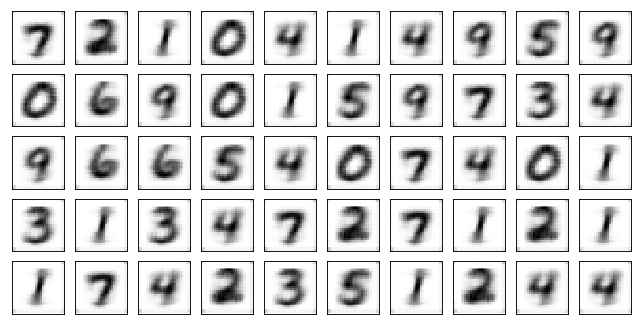

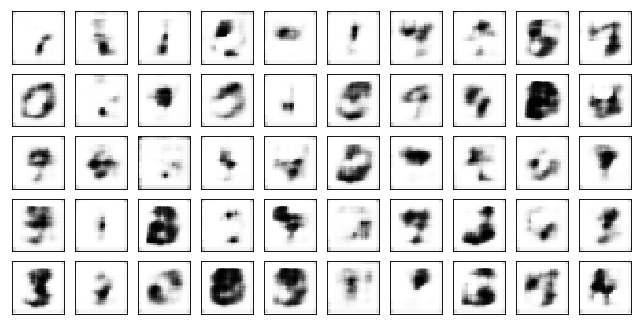

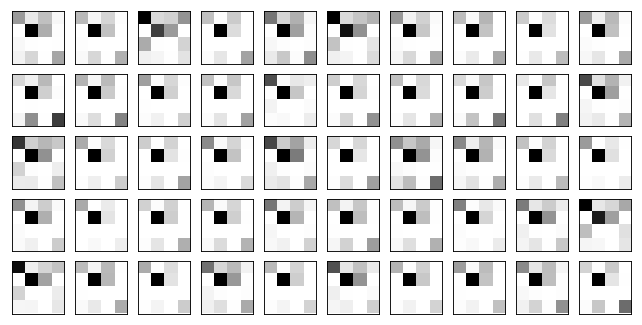

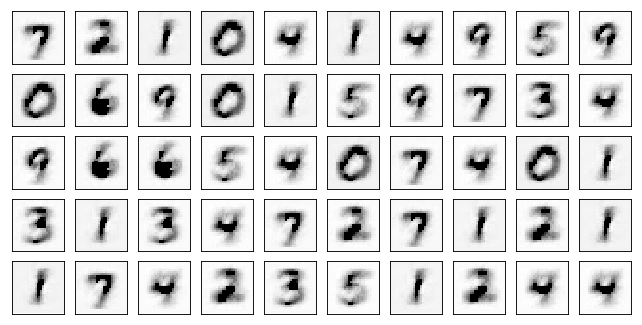

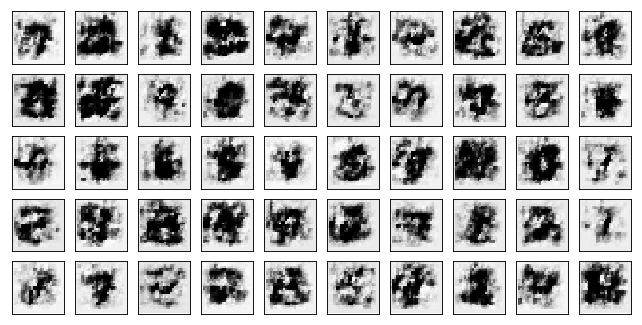

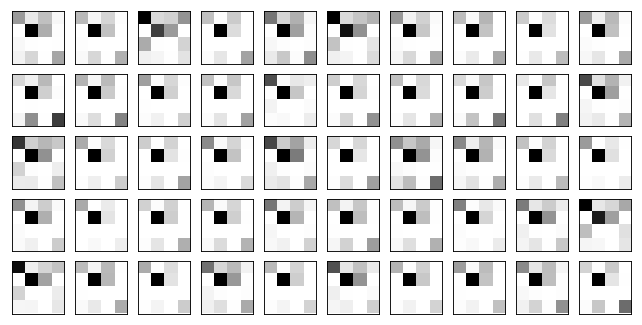

Test losses: Adam Discr: 9.43795385/0.00010031 Adam Discr+bn+dp: 11.00840062/0.00088397
Train Epoch: 8 [0/50000 (0%)]	Losses Adam Discr: AE:9.0027 D:0.0003 Adam Discr+bn+dp: AE:8.5336 D:0.0006
Train Epoch: 8 [10000/50000 (20%)]	Losses Adam Discr: AE:8.5558 D:0.0013 Adam Discr+bn+dp: AE:7.9391 D:0.0018
Train Epoch: 8 [20000/50000 (40%)]	Losses Adam Discr: AE:9.5957 D:0.0002 Adam Discr+bn+dp: AE:9.3412 D:0.0008
Train Epoch: 8 [30000/50000 (60%)]	Losses Adam Discr: AE:9.1855 D:0.0003 Adam Discr+bn+dp: AE:8.5452 D:0.0016
Train Epoch: 8 [40000/50000 (80%)]	Losses Adam Discr: AE:9.4791 D:0.0002 Adam Discr+bn+dp: AE:9.0370 D:0.0063
Train Epoch: 8 [50000/50000 (100%)]	Losses Adam Discr: AE:9.6405 D:0.0002 Adam Discr+bn+dp: AE:7.9084 D:0.0020


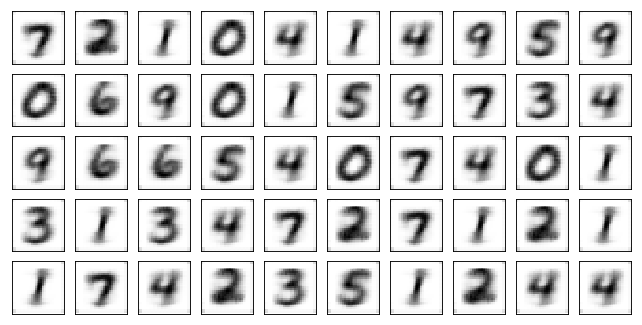

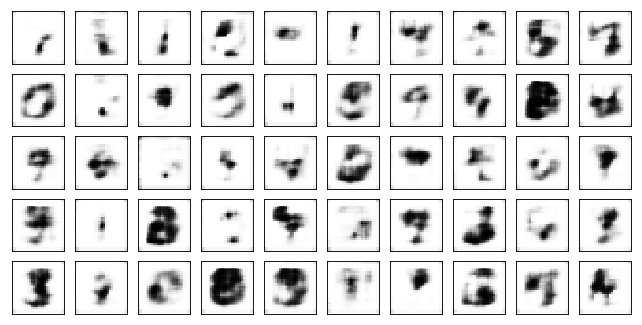

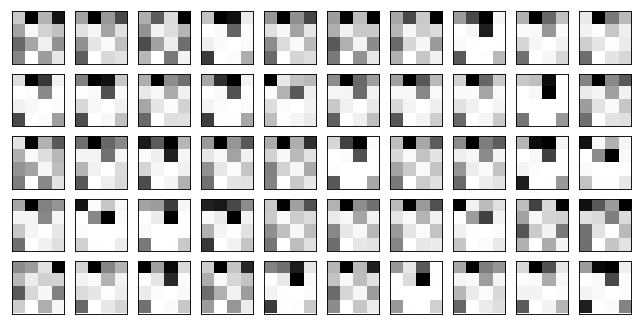

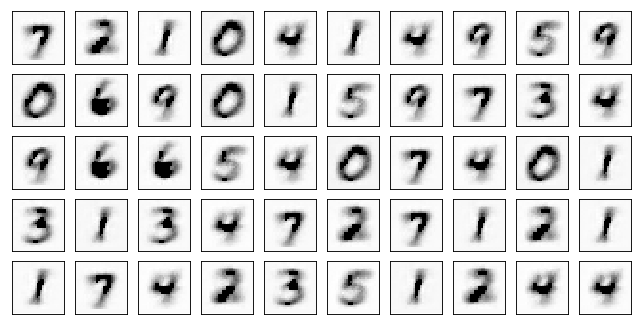

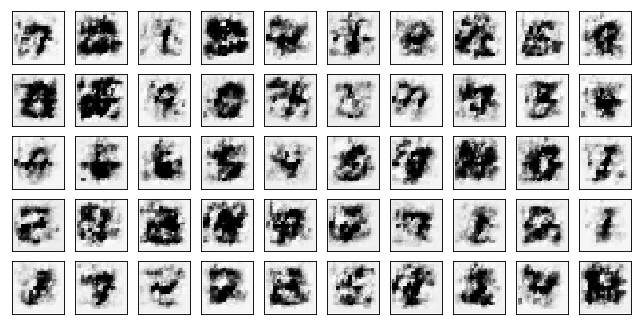

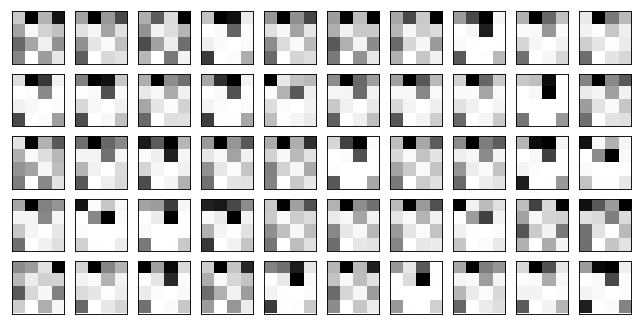

Test losses: Adam Discr: 9.92520729/0.00007533 Adam Discr+bn+dp: 12.46033165/0.00086086
Train Epoch: 9 [0/50000 (0%)]	Losses Adam Discr: AE:9.8531 D:0.0001 Adam Discr+bn+dp: AE:8.2515 D:0.0085
Train Epoch: 9 [10000/50000 (20%)]	Losses Adam Discr: AE:9.9236 D:0.0001 Adam Discr+bn+dp: AE:8.3919 D:0.0162
Train Epoch: 9 [20000/50000 (40%)]	Losses Adam Discr: AE:9.8474 D:0.0002 Adam Discr+bn+dp: AE:8.3801 D:0.0012
Train Epoch: 9 [30000/50000 (60%)]	Losses Adam Discr: AE:9.9070 D:0.0002 Adam Discr+bn+dp: AE:9.4583 D:0.0004
Train Epoch: 9 [40000/50000 (80%)]	Losses Adam Discr: AE:9.4428 D:0.0008 Adam Discr+bn+dp: AE:9.5310 D:0.0021
Train Epoch: 9 [50000/50000 (100%)]	Losses Adam Discr: AE:9.7728 D:0.0001 Adam Discr+bn+dp: AE:8.3795 D:0.0007


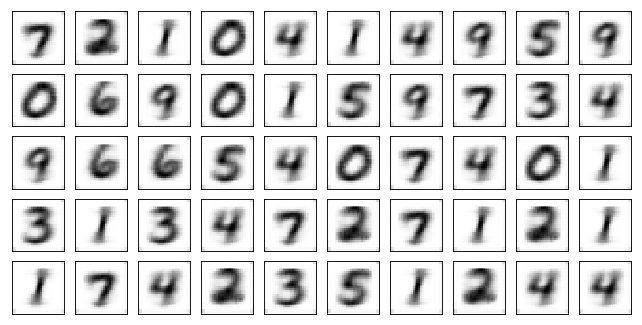

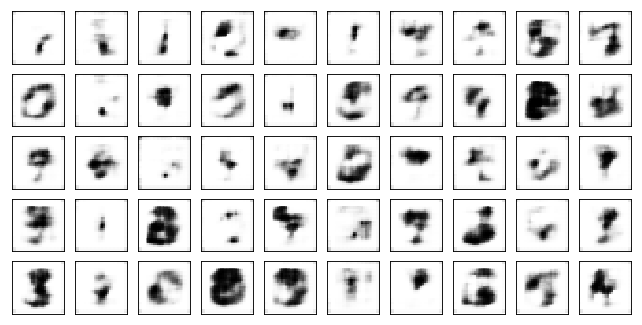

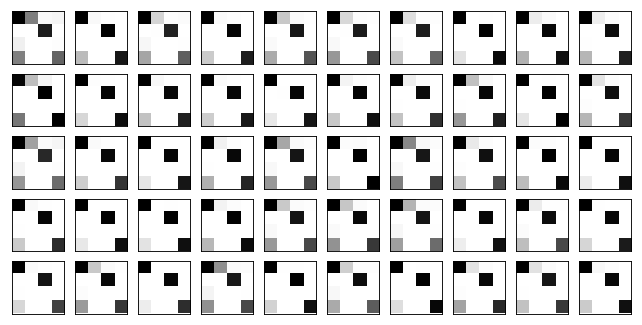

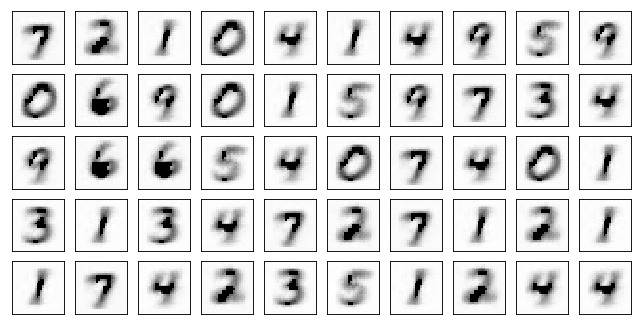

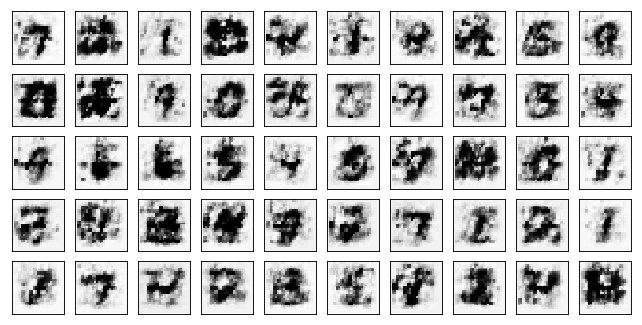

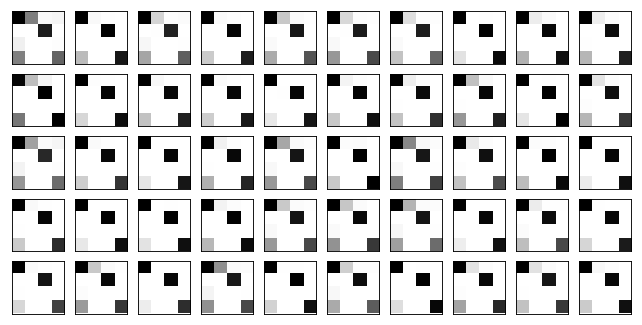

Test losses: Adam Discr: 10.00887263/0.00008185 Adam Discr+bn+dp: 9.52990784/0.00111761
Train Epoch: 10 [0/50000 (0%)]	Losses Adam Discr: AE:10.2600 D:0.0005 Adam Discr+bn+dp: AE:8.6673 D:0.0027
Train Epoch: 10 [10000/50000 (20%)]	Losses Adam Discr: AE:10.3437 D:0.0001 Adam Discr+bn+dp: AE:8.0332 D:0.0071
Train Epoch: 10 [20000/50000 (40%)]	Losses Adam Discr: AE:10.8064 D:0.0001 Adam Discr+bn+dp: AE:8.3239 D:0.0007
Train Epoch: 10 [30000/50000 (60%)]	Losses Adam Discr: AE:9.5126 D:0.0002 Adam Discr+bn+dp: AE:9.1280 D:0.0004
Train Epoch: 10 [40000/50000 (80%)]	Losses Adam Discr: AE:7.2775 D:0.0204 Adam Discr+bn+dp: AE:8.8544 D:0.0066
Train Epoch: 10 [50000/50000 (100%)]	Losses Adam Discr: AE:8.1087 D:0.0031 Adam Discr+bn+dp: AE:9.3206 D:0.0002


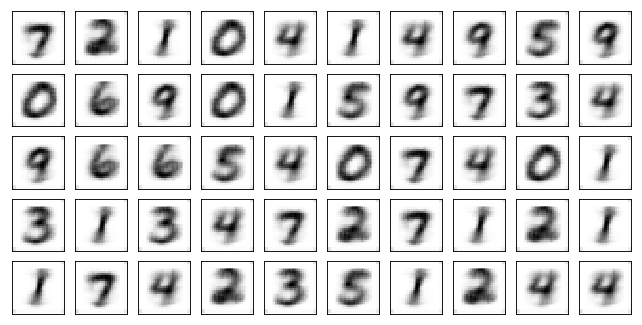

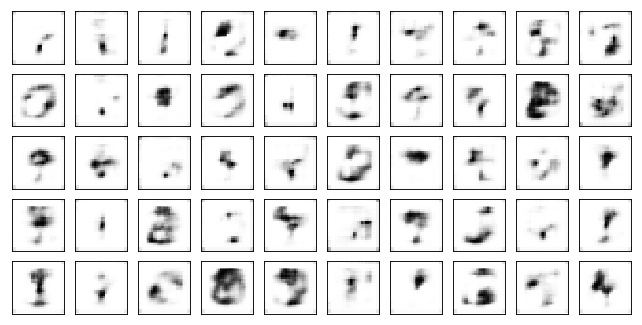

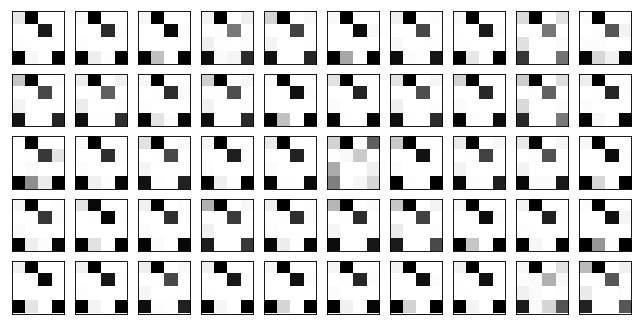

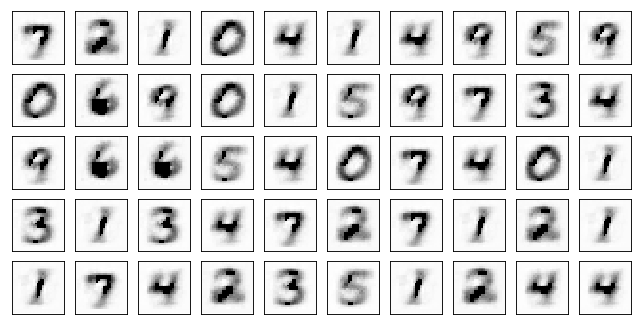

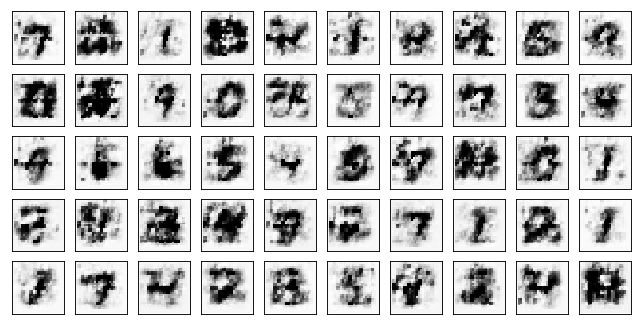

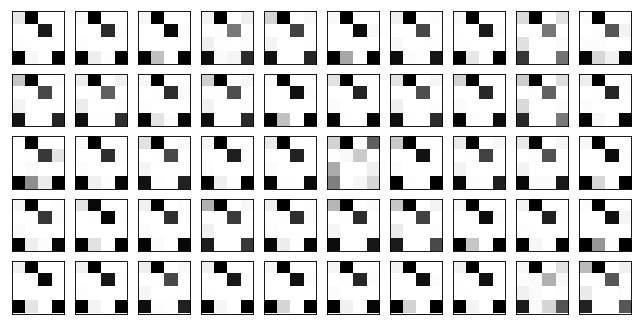

Test losses: Adam Discr: 7.16566638/0.00152265 Adam Discr+bn+dp: 10.91896364/0.00199350


In [14]:
for epoch in range(1, 11):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

In [15]:
torch.save(models['Adam Discr+bn+dp'], './adam_ds_oh_1')
torch.save(models['Adam Discr+bn+dp'], './adam_ds_bndp_oh_1')

/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ConvLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FullyConnected. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't r

### Вывод результатов

In [16]:
model = torch.load('./adam_ds_oh')

In [17]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(-1, 1).data.numpy()
with torch.no_grad():
    encoded = model.encode(data)
    enc_to_lot = encoded.view(-1, 1, 4, 4).clamp(-1, 1).data.numpy()
    print ('enc=', encoded.shape)


TypeError: forward() missing 1 required positional argument: 'y'

In [ ]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_latent(enc_to_lot, (5, 10))

In [ ]:
def show_generated_samples():
    pred_z = torch.randn((50, 10))
       
    pred_gen = model.decode(pred_z)
    generated = pred_gen.view(-1, 1, 28, 28).data.numpy()  
    plot_mnist(generated, (5, 10))

In [ ]:
show_generated_samples()